In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/CV project/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1cuAm9nQjaZ7lACWZQj1O_5vAcqnj3c_T/CV project


## Import

In [ ]:
import sys
import os
os.environ["HDF5_USE_FILE_LOCKING"]='FALSE'
import h5py
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import torch
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from display import get_cmap, vil_cmap, vis_cmap, ir_cmap, c09_cmap
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from model import SmaAt_UNet
import cv2
import torchvision.transforms as T
from torchvision import models, datasets, transforms
from tqdm import tqdm
from io import BytesIO
import copy
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [ ]:
from tensorflow import keras
import torch
import torchvision.transforms as T

In [ ]:
op_size = 96

### Load original test data and save Nx25x96x96

In [ ]:
data_path = 'data/'
DEST_TRAIN_FILE= os.path.join(data_path,'nowcast_training_000.h5')
DEST_TEST_FILE= os.path.join(data_path, 'nowcast_testing_000.h5')

In [ ]:
# N_TRAIN = 50
# with h5py.File(DEST_TRAIN_FILE,'r') as hf:
#     Nr = N_TRAIN if N_TRAIN>=0 else hf['IN_vil'].shape[0]
#     X = hf['IN_vil'][:Nr]
#     Y = hf['OUT_vil'][:Nr]

In [ ]:
N_TEST=500

with h5py.File(DEST_TEST_FILE,'r') as hf:
    Nr = N_TEST if N_TEST>=0 else hf['IN_vil'].shape[0]
    X_test = hf['IN_vil'][:Nr]
    Y_test = hf['OUT_vil'][:Nr]

KeyboardInterrupt: ignored

Add all frames (12 + 13 = 25) in order

In [ ]:
data = np.concatenate((X_test,Y_test),axis=3)
data.shape

(500, 384, 384, 25)

In [ ]:
del X_test
del Y_test

#### Downsample and blur images

In [ ]:
data = torch.tensor(data)
data.shape

torch.Size([500, 384, 384, 25])

In [ ]:
## We need to use downsampled data for training our model because colab suxx

## input shape is = (n_egs, height, width, num_frames). For now height = width --> Is a torch tensor
## op_size is the height/width we would want our downsampled output to have
## sigma: The variance of the gaussian blur that we will apply to the images before downsampling

def blur_downsample(input, op_size, kernel_size=(5,5) ,sigma=(1,1)):
  
  n_egs, ip_h, ip_w, num_frames = input.shape 
  op = torch.zeros((n_egs, op_size, op_size, num_frames))

  # Define the blur transformation
  blur_transform = T.GaussianBlur(kernel_size=kernel_size, sigma=sigma)
  ds_transform = T.Resize((op_size,op_size))

  for eg in range(n_egs):
    cur_seq = input[eg,:,:,:]
    for frame_num in range(num_frames):
      cur_img = cur_seq[:,:,frame_num]

      ## First apply Gaussian blur to this image 
      cur_img_blrd = blur_transform(cur_img[None,:,:])
      
      ## Now downsample this blurred image
      cur_img_ds = ds_transform(cur_img_blrd)[0]
      op[eg,:,:,frame_num] = cur_img_ds 
  
  return op

In [ ]:
data = blur_downsample(data.float(), op_size)
data.shape

torch.Size([500, 96, 96, 25])

#### Reshape data
Reshape from (N, W, W, T) to (N, T, W, W)

In [ ]:
data = torch.transpose(data, 2, 3)
data = torch.transpose(data, 1, 2).float()
data.shape

torch.Size([500, 25, 96, 96])

#### Save data

In [ ]:
torch.save(data, 'test_500_25_96_96.pt') #torch.Size([500, 96, 96, 25])

NameError: ignored

### Load test data: 500_25_96_96

In [ ]:
data = torch.load('test_500_25_96_96.pt')

In [ ]:
data = data.numpy()

In [ ]:
data.shape

(500, 25, 96, 96)

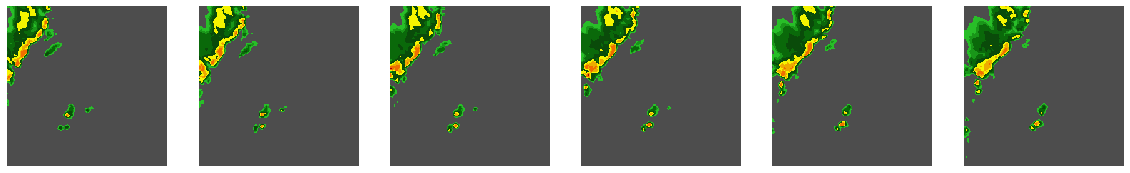

In [ ]:
img_index=8
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,6,figsize=(20,8))
for i in range(6):
    axs[i].imshow(data[img_index,2*i,:,:],origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) 
    axs[i].set_axis_off()

### Normalize (scale by mean and stdev)



In [ ]:
# MEAN = np.mean(data)
# print("MEAN =", MEAN)
# SCALE = np.std(data)
# print("SCALE =", SCALE)

MEAN = 33.44
SCALE = 47.54

### Set up data for model

In [ ]:
dt = (data.reshape((500,25,op_size,op_size,1)) - MEAN )/ SCALE
dt.shape

(500, 25, 96, 96, 1)

#### Upload models

In [ ]:
alpha = 0.5

In [ ]:
# model_train = keras.models.load_model("convlstm_train_alpha"+str(alpha))
model_enc = keras.models.load_model("convlstm_enc_alpha"+str(alpha))
model_dec = keras.models.load_model("convlstm_dec_alpha"+str(alpha))

#### define predictor

In [ ]:
def predict_sample_sequence(model_enc, model_dec, source, n_steps, op_size):
		# encode
		state_h_1, state_c_1, state_h_2, state_c_2, state_h_3, state_c_3 = model_enc.predict(source)
		decoder_input = np.repeat(0,op_size*op_size).reshape((1,1,op_size,op_size,1))
		# collect predictions
		output = list()
		for t in range(n_steps):
				# predict next char
				yhat, h_1, c_1, h_2, c_2, h_3, c_3 = model_dec.predict([decoder_input, state_h_1, state_c_1, state_h_2, state_c_2, state_h_3, state_c_3])
				# store prediction
				output.append(yhat[0,0,:])
				# update state
				state_h_1, state_c_1, state_h_2, state_c_2, state_h_3, state_c_3 = h_1, c_1, h_2, c_2, h_3, c_3
				# update target sequence
				decoder_input = yhat
		return np.array(output)

In [ ]:
def get_prediction_list(model_enc, model_dec, input, n_steps):
    n_input, f, op_size, _, _ = input.shape
    prediction_list = np.zeros((n_input, 12, op_size, op_size))

    for sample_i in range(n_input):
        source = input[np.newaxis,sample_i,:,:,:,:]
        output = predict_sample_sequence(model_enc, model_dec, source, n_steps, op_size)
        prediction_list[sample_i,:,:,:] = output[:,:,:,0]
    return prediction_list

#### get predictions

In [ ]:
input = dt[:,:13,:,:,:]
print(input.shape)

Y_pred = get_prediction_list(model_enc, model_dec, input, 12)
print(Y_pred.shape)

(500, 13, 96, 96, 1)
(500, 12, 96, 96)


In [ ]:
h5f = h5py.File('convlstm_pred.h5', 'w')
h5f.create_dataset('Y_pred', data=Y_pred)

h5f.close()

#### load predictions

In [ ]:
with h5py.File('convlstm_pred.h5','r') as hf:
    Y_pred = hf['Y_pred'][:]

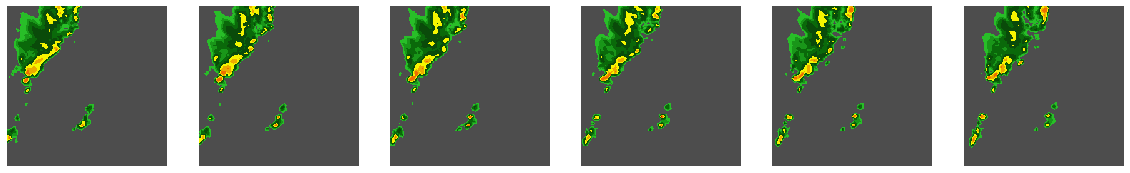

In [ ]:
#plot target
target = dt[:,13:,:,:,:]
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,6,figsize=(20,8))
for i in range(6):
    axs[i].imshow(target[8,i,:,:,0]*SCALE + MEAN,origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) 
    axs[i].set_axis_off()

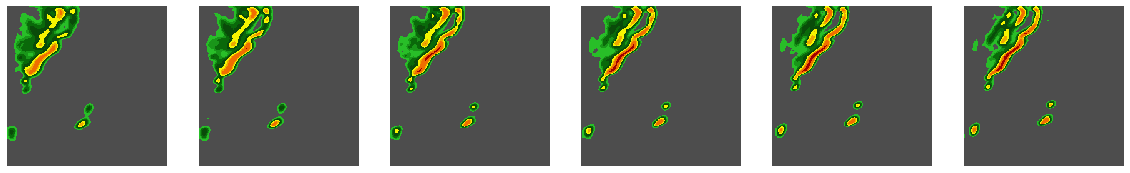

In [ ]:
#plot prediction
cmap,norm,vmin,vmax=get_cmap('vil')
fig,axs=plt.subplots(1,6,figsize=(20,8))
for i in range(6):
    axs[i].imshow(Y_pred[8,i,:,:]*SCALE + MEAN,origin='lower',cmap=cmap,norm=norm,vmin=vmin,vmax=vmax) 
    axs[i].set_axis_off()

#### plotting functions 

In [ ]:
## 
# Functions for plotting results
##

norm = {'scale':SCALE,'shift':MEAN}
hmf_colors = np.array( [
    [82,82,82], 
    [252,141,89],
    [255,255,191],
    [145,191,219]
])/255

# Model that implements persistence forecast that just repeasts last frame of input
class persistence:
    def predict(self,x_test):
        return np.tile(x_test[:,-1:,:,:],[1,12,1,1])

def plot_hit_miss_fa(ax,y_true,y_pred,thres):       ## Takes input as numpy array
    mask = np.zeros_like(y_true)
    mask[np.logical_and(y_true>=thres,y_pred>=thres)]=4
    mask[np.logical_and(y_true>=thres,y_pred<thres)]=3
    mask[np.logical_and(y_true<thres,y_pred>=thres)]=2
    mask[np.logical_and(y_true<thres,y_pred<thres)]=1
    cmap=ListedColormap(hmf_colors)
    ax.imshow(mask,cmap=cmap)


def visualize_result(models,x_test,y_test,idx,ax,labels, thresh):
    fs=10
    cmap_dict = lambda s: {'cmap':get_cmap(s,encoded=True)[0],
                           'norm':get_cmap(s,encoded=True)[1],
                           'vmin':get_cmap(s,encoded=True)[2],
                           'vmax':get_cmap(s,encoded=True)[3]}
    # print(x_test.shape) #(N, 13, 64, 64, 1)
    for i in range(1,13,3):
        ax[(i-1)//3][0].imshow(x_test[idx,i,:,:,0]*norm['scale']+norm['shift'],cmap=get_cmap('vil')[0])
    ax[0][0].set_title('Inputs',fontsize=fs)
    
    pers = persistence().predict(x_test[idx:idx+1,:,:,:,0])

    x_test = x_test[idx:idx+1]
    y_test = y_test[idx:idx+1]
    y_preds=[]
    for i,ms in enumerate(models):
        m_enc = ms[0]
        m_dec = ms[1]
        yp = get_prediction_list(m_enc, m_dec, x_test, 12)
        yp=yp[0]
        y_preds.append(yp)
        # print("TESTING HERE0: ", yp.shape) #(12, op_size, op_size)
    
    #y_test.shape = (1, 12, op_size, op_size, 1)
    for i in range(0,12,3):
        ax[i//3][2].imshow(y_test[0,i,:,:,0]*norm['scale']+norm['shift'],**cmap_dict('vil'))  ## Change this line --> CHANGED 
    ax[0][2].set_title('Target',fontsize=fs)
    


    # Plot Persistence
    for i in range(0,12,3):
        # print("TESTING HERE1: ", y_test.shape) #(1, 12, op_size, op_size, 1)
        # print("TESTING HERE2: ", pers.shape) #(1, 12, op_size, op_size)
        plot_hit_miss_fa(ax[i//3][4],y_test[0,i,:,:,0]*norm['scale']+norm['shift'],pers[0,i,:,:]*norm['scale']+norm['shift'],thresh)    ## Change this LINE --> ALSO make threshold a variable value
    ax[0][4].set_title('Persistence\nScores',fontsize=fs)
    
    for k,m in enumerate(models):
        for i in range(0,12,3):
            ax[i//3][5+2*k].imshow(y_preds[k][i,:,:]*norm['scale']+norm['shift'],**cmap_dict('vil'))
            plot_hit_miss_fa(ax[i//3][5+2*k+1],y_test[0,i,:,:,0]*norm['scale']+norm['shift'],y_preds[k][i,:,:]*norm['scale']+norm['shift'],thresh)  ## CHANGE THIS LINE, based on shapes of inputs and outputs

        ax[0][5+2*k].set_title(labels[k],fontsize=fs)
        ax[0][5+2*k+1].set_title(labels[k]+'\nScores',fontsize=fs)
        
    for j in range(len(ax)):
        for i in range(len(ax[j])):
            ax[j][i].xaxis.set_ticks([])
            ax[j][i].yaxis.set_ticks([])
    for i in range(4):
        ax[i][1].set_visible(False)
    for i in range(4):
        ax[i][3].set_visible(False)
    ax[0][0].set_ylabel('-45 Minutes')
    ax[1][0].set_ylabel('-30 Minutes')
    ax[2][0].set_ylabel('-15 Minutes')
    ax[3][0].set_ylabel('  0 Minutes')
    ax[0][2].set_ylabel('+15 Minutes')
    ax[1][2].set_ylabel('+30 Minutes')
    ax[2][2].set_ylabel('+45 Minutes')
    ax[3][2].set_ylabel('+60 Minutes')
    
    legend_elements = [Patch(facecolor=hmf_colors[1], edgecolor='k', label='False Alarm'),
                   Patch(facecolor=hmf_colors[2], edgecolor='k', label='Miss'),
                   Patch(facecolor=hmf_colors[3], edgecolor='k', label='Hit')]
    ax[-1][-1].legend(handles=legend_elements, loc='lower right', bbox_to_anchor= (-5.4, -.35), 
                           ncol=5, borderaxespad=0, frameon=False, fontsize='16')
    plt.subplots_adjust(hspace=0.05, wspace=0.05)

In [ ]:
## Y_test and Y_pred are (#samples, #frames, H,W) shaped --> Neither on GPU, but input as torch tensors

def get_eval_metrics(y_pred,y_true,thres):
  # y_pred = y_pred.numpy()
  # y_true = y_true.numpy()
  y_pred = (y_pred *SCALE) + MEAN
  y_true = (y_true *SCALE) + MEAN
  total_mask = np.zeros_like(y_true) ; 
  
  results_dict = {}
  results_dict['POD'] = [] ; 
  results_dict['SUCR'] = [] ; 
  results_dict['CSI'] = [] ; 
  results_dict['Bias'] = [] ; 

  for frame_num in range(y_true.shape[1]):
    for idx in range(y_true.shape[0]):

      # print("Frame number = ", frame_num)
      # print("IDX = ", idx)

      mask = np.zeros_like(y_true[0,0,:,:])
      y_pred_ = y_pred[idx,frame_num,:,:]
      y_true_ = y_true[idx,frame_num,:,:]
      mask[np.logical_and(y_true_>=thres,y_pred_>=thres)]=4
      mask[np.logical_and(y_true_>=thres,y_pred_<thres)]=3
      mask[np.logical_and(y_true_<thres,y_pred_>=thres)]=2
      mask[np.logical_and(y_true_<thres,y_pred_<thres)]=1

      total_mask[idx,frame_num,:,:] = mask 


    hits_ = np.count_nonzero(total_mask[:,frame_num,:,:]==4)
    miss_ = np.count_nonzero(total_mask[:,frame_num,:,:]==3)
    false_al_ = np.count_nonzero(total_mask[:,frame_num,:,:]==2)
    true_neg_ = np.count_nonzero(total_mask[:,frame_num,:,:]==1) 
    # print("HITS", hits_)
    # print("MISS", miss_)
    # print("FA", false_al_)
    # print("TN", true_neg_)

    #print("START", results_dict)
    results_dict['POD'].append((hits_/(hits_+miss_)))
    results_dict['SUCR'].append((hits_/(hits_+false_al_)))
    results_dict['CSI'].append((hits_/(hits_+miss_+false_al_)))
    results_dict['Bias'].append((hits_+false_al_/(hits_+miss_)))
    #print("END", results_dict)


  hits = np.count_nonzero(total_mask==4)
  miss = np.count_nonzero(total_mask==3)
  false_al = np.count_nonzero(total_mask==2)
  true_neg = np.count_nonzero(total_mask==1)

  
  results_dict['POD_total'] = hits/(hits+miss) ; 
  results_dict['SUCR_total'] = hits/(hits+false_al) ; 
  results_dict['CSI_total'] = hits/(hits+miss+false_al) ; 
  results_dict['Bias_total'] = (hits+false_al)/(hits+miss) ; 


  return total_mask, results_dict

### outputs

In [ ]:
X_test = dt[:,:13,:,:,:]
Y_test = dt[:,13:,:,:,:]

print(X_test.shape)
print(Y_test.shape)

(500, 13, 96, 96, 1)
(500, 12, 96, 96, 1)


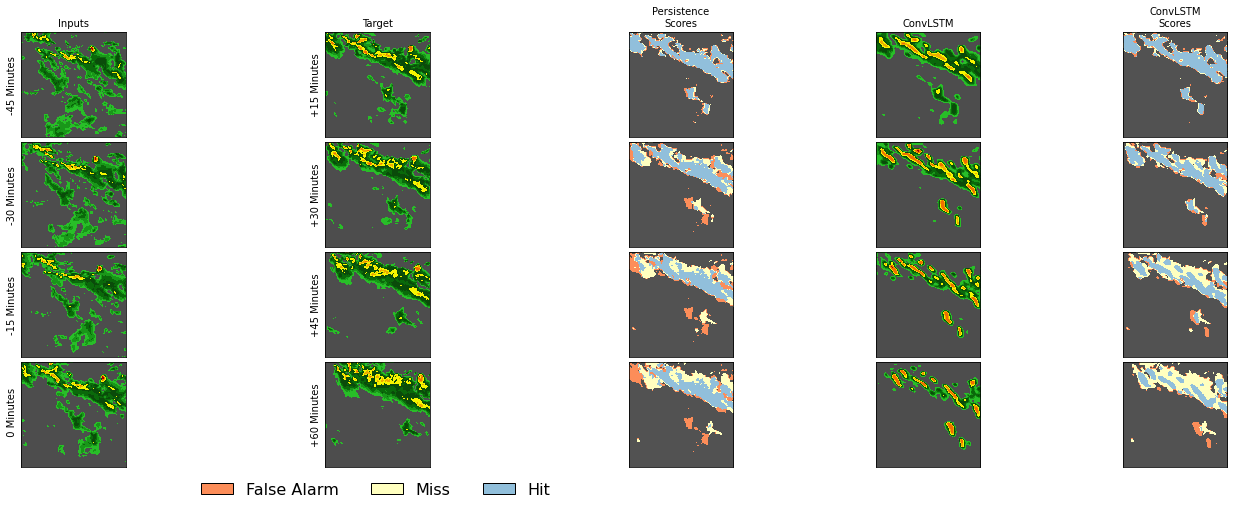

In [ ]:
idx = 14 # adjust this to pick a case
models = [(model_enc, model_dec)]
fig,ax = plt.subplots(4,7,figsize=(24,8), gridspec_kw={'width_ratios': [1,.2,1,.2,1,1,1]})
visualize_result(models,X_test,Y_test,idx,ax,labels=['ConvLSTM'], thresh=74)

In [ ]:
Y_true = dt[:,13:,:,:,0]
print(Y_true.shape)

Y_pred
print(Y_pred.shape)

(500, 12, 96, 96)
(500, 12, 96, 96)


In [ ]:
m1, res_dict16 = get_eval_metrics(Y_pred, Y_true, 16) ; 

In [ ]:
m1, res_dict74 = get_eval_metrics(Y_pred, Y_true, 74) ; 

In [ ]:
m1, res_dict133 = get_eval_metrics(Y_pred, Y_true, 133) ;

In [ ]:
import json

with open('results_unet_16.json') as json_file:
    data_16 = json.load(json_file)
    print(data_16)


{'POD': [0.8872750469589012, 0.8645912566163497, 0.8469697695025934, 0.8263157125100534, 0.8049967109002805, 0.786635683364375, 0.7652078959071932, 0.7443431129186872, 0.7289956612940123, 0.7158634645288902, 0.7009951993750735, 0.6850477737398288], 'SUCR': [0.9696388674056887, 0.9413718396140834, 0.9215004948006076, 0.9103009657021102, 0.901027765995628, 0.8904501391055256, 0.8832298664567133, 0.8763962878258765, 0.8671814734142711, 0.8578160708432043, 0.847421534934308, 0.835793020365781], 'CSI': [0.8632909479708198, 0.8204149436256318, 0.7899728454010315, 0.7641001463088785, 0.7395985748451782, 0.7172242762938881, 0.6949065148778125, 0.673626224216348, 0.6557757856214211, 0.639932221556424, 0.6224349650518571, 0.6037842727642563], 'Bias': [902695.0277821736, 882056.0538463047, 866932.0721504852, 847614.081423314, 828468.0884238265, 810079.0967778272, 789755.1011666743, 767944.1049794176, 752064.1116538263, 737950.1186551332, 721493.1262143657, 703492.134590291], 'MSE': [], 'POD_total

In [ ]:
with open('results_unet_74.json') as json_file:
    data_74 = json.load(json_file)
    print(data_74)

{'POD': [0.5759514833633831, 0.5612471480235749, 0.5412071708551791, 0.5316192965261897, 0.5114800277775964, 0.4820202830209237, 0.45844540837456677, 0.4312228865451634, 0.409239211358401, 0.38411953650007125, 0.35300141747338115, 0.3245761461180777], 'SUCR': [0.9884294854965382, 0.9666471313076669, 0.9471408928687054, 0.9275671279934943, 0.911833991143814, 0.8988589633145327, 0.8853533482631464, 0.8735701971698657, 0.864065281213158, 0.8553816859116764, 0.8467787424944515, 0.8354538032385359], 'CSI': [0.5720943863152868, 0.5505850230671129, 0.5253396542508805, 0.510429496602964, 0.4873766026871003, 0.45722163887258266, 0.4327548070493102, 0.4058912557785168, 0.38448546142040707, 0.3606950578013856, 0.33180747779384423, 0.30507379749115443], 'Bias': [263541.00674206414, 257306.0193650835, 248669.03020430016, 244093.04151366657, 234955.04945544156, 221202.05423768703, 210321.05936525928, 197115.06240989527, 186893.06438149794, 175195.06494261065, 160628.06387420747, 147354.06392665903],

In [ ]:
with open('results_unet_133.json') as json_file:
    data_133 = json.load(json_file)
    print(data_133)

{'POD': [0.160869441087182, 0.15345077288604073, 0.13784527513262537, 0.1174431305504108, 0.09709848015627233, 0.07753277882292274, 0.06412105811209722, 0.0513925441767649, 0.03885195614518923, 0.02547203592408714, 0.01707551474085795, 0.01061757256964738], 'SUCR': [0.9911462914101437, 0.9487329548779774, 0.8994261738754858, 0.8420730046308907, 0.7874806800618238, 0.737688533527167, 0.6862985685071574, 0.630663669703064, 0.5793650793650794, 0.5174990169091624, 0.47514856834143704, 0.4296413086322428], 'CSI': [0.1606386011593652, 0.15218881138576215, 0.13575280082697735, 0.11491208505260027, 0.0946190630948512, 0.075452585405747, 0.06229523411759246, 0.049890971708796195, 0.03778610149073935, 0.024881124566329182, 0.01675940394069896, 0.010469997214404411], 'Bias': [16904.001437014056, 16211.008292078037, 14577.015413857342, 12365.02202592962, 10190.0262042022, 8119.027569544582, 6712.029309208327, 5331.030097078019, 4015.0282075845985, 2632.0237493830386, 1759.0188616970675, 1090.01409

Text(0.5, 0, 'Lead time')

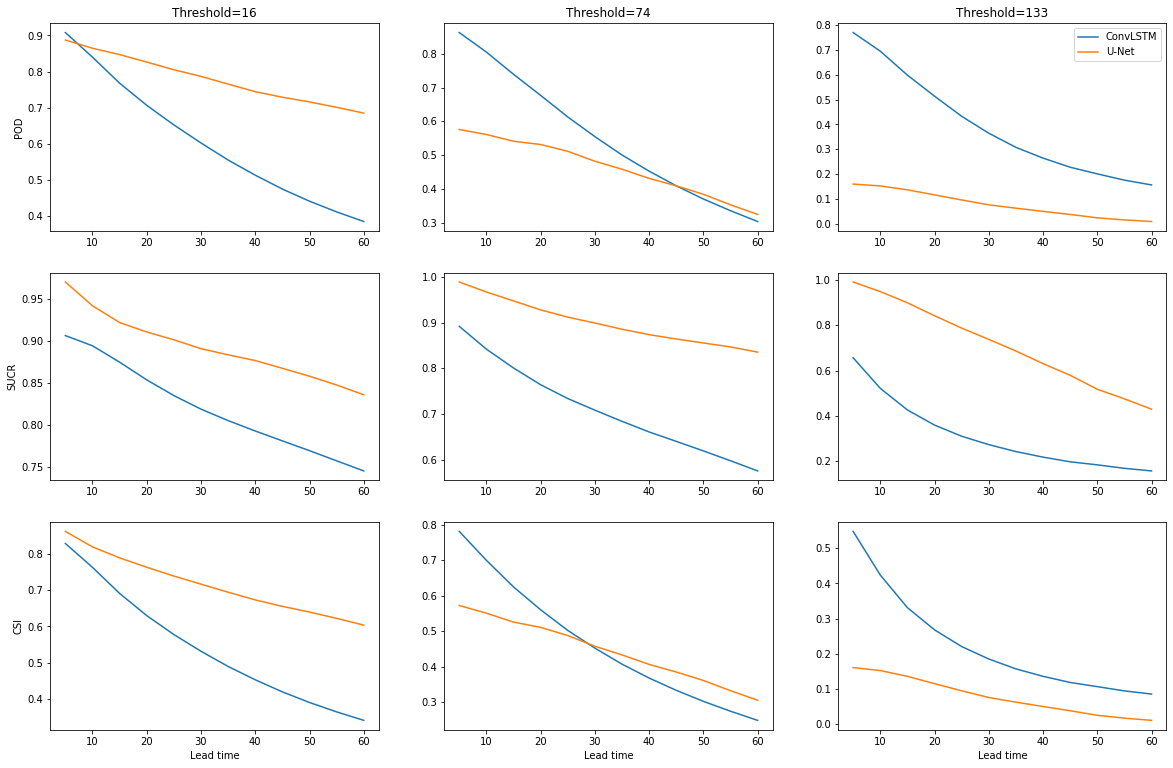

In [ ]:
fig,axs=plt.subplots(3,3,figsize=(20,13))

axs[0][0].set_ylabel("POD")
axs[0][0].plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16['POD'],label='ConvLSTM')
axs[0][0].plot([5,10,15,20,25,30,35,40,45,50,55,60], data_16['POD'], label='U-Net')

axs[0][1].plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74['POD'],label='ConvLSTM')
axs[0][1].plot([5,10,15,20,25,30,35,40,45,50,55,60], data_74['POD'], label='U-Net')

axs[0][2].plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133['POD'],label='ConvLSTM')
axs[0][2].plot([5,10,15,20,25,30,35,40,45,50,55,60], data_133['POD'], label='U-Net')

axs[1][0].set_ylabel("SUCR")
axs[1][0].plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16['SUCR'],label='ConvLSTM')
axs[1][0].plot([5,10,15,20,25,30,35,40,45,50,55,60], data_16['SUCR'], label='U-Net')

axs[1][1].plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74['SUCR'],label='ConvLSTM')
axs[1][1].plot([5,10,15,20,25,30,35,40,45,50,55,60], data_74['SUCR'], label='U-Net')

axs[1][2].plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133['SUCR'],label='ConvLSTM')
axs[1][2].plot([5,10,15,20,25,30,35,40,45,50,55,60], data_133['SUCR'], label='U-Net')


axs[2][0].set_ylabel("CSI")
axs[2][0].plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict16['CSI'],label='ConvLSTM')
axs[2][0].plot([5,10,15,20,25,30,35,40,45,50,55,60], data_16['CSI'], label='U-Net')

axs[2][1].plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict74['CSI'],label='ConvLSTM')
axs[2][1].plot([5,10,15,20,25,30,35,40,45,50,55,60], data_74['CSI'], label='U-Net')

axs[2][2].plot([5,10,15,20,25,30,35,40,45,50,55,60] ,res_dict133['CSI'],label='ConvLSTM')
axs[2][2].plot([5,10,15,20,25,30,35,40,45,50,55,60], data_133['CSI'], label='U-Net')


axs[0][2].legend()

axs[0][0].set_title("Threshold=16")
axs[0][1].set_title("Threshold=74")
axs[0][2].set_title("Threshold=133")


axs[2][0].set_xlabel("Lead time")
axs[2][1].set_xlabel("Lead time")
axs[2][2].set_xlabel("Lead time")

In [ ]:
print("POD")
print()

print("threshold=16")
print("ConvLSTM", round(res_dict16['POD_total'],4))
print("U-Net", round(data_16['POD_total'],4))
print()
print("threshold=74")
print("ConvLSTM", round(res_dict74['POD_total'],4))
print("U-Net", round(data_74['POD_total'],4))
print()
print("threshold=133")
print("ConvLSTM", round(res_dict133['POD_total'],4))
print("U-Net", round(data_133['POD_total'],4))

POD

threshold=16
ConvLSTM 0.6042
U-Net 0.7795

threshold=74
ConvLSTM 0.5526
U-Net 0.4639

threshold=133
ConvLSTM 0.3942
U-Net 0.0798


In [ ]:
print("SUCR")
print()

print("threshold=16")
print("ConvLSTM", round(res_dict16['SUCR_total'],4))
print("U-Net", round(data_16['SUCR_total'],4))
print()
print("threshold=74")
print("ConvLSTM", round(res_dict74['SUCR_total'],4))
print("U-Net", round(data_74['SUCR_total'],4))
print()
print("threshold=133")
print("ConvLSTM", round(res_dict133['SUCR_total'],4))
print("U-Net", round(data_133['SUCR_total'],4))

SUCR

threshold=16
ConvLSTM 0.83
U-Net 0.8932

threshold=74
ConvLSTM 0.729
U-Net 0.9056

threshold=133
ConvLSTM 0.3179
U-Net 0.7963


In [ ]:
print("CSI")
print()

print("threshold=16")
print("ConvLSTM", round(res_dict16['CSI_total'],4))
print("U-Net", round(data_16['CSI_total'],4))
print()
print("threshold=74")
print("ConvLSTM", round(res_dict74['CSI_total'],4))
print("U-Net", round(data_74['CSI_total'],4))
print()
print("threshold=133")
print("ConvLSTM", round(res_dict133['CSI_total'],4))
print("U-Net", round(data_133['CSI_total'],4))

CSI

threshold=16
ConvLSTM 0.5376
U-Net 0.7131

threshold=74
ConvLSTM 0.4584
U-Net 0.4425

threshold=133
ConvLSTM 0.2136
U-Net 0.0782


In [ ]:
import json

alpha = 0

In [ ]:
with open('results_unet0_16.json') as json_file:
    data_0_16 = json.load(json_file)
    print(data_0_16)

{'POD': [0.9044655093369472, 0.8739294764020509, 0.8502286859023678, 0.8292810997072665, 0.809872958169509, 0.7920795156412569, 0.7726317946492024, 0.7589694503880796, 0.7486033424816693, 0.7350120052431508, 0.72452249334816, 0.7152968863495179], 'SUCR': [0.9672301195778518, 0.9453091768350131, 0.9261281025497223, 0.9123252044899051, 0.9002358384175947, 0.8887949209352306, 0.8810346432417547, 0.8710932643740754, 0.8593165462524391, 0.8479262389068831, 0.8336876451299503, 0.8177804123252294], 'CSI': [0.8775736621009617, 0.8318692095550723, 0.796230082576878, 0.7680703294520942, 0.743173067874853, 0.7206591983500159, 0.6996398948593007, 0.6823335957026906, 0.666872761150305, 0.6494055279428017, 0.6330278188849059, 0.6169628816238948], 'Bias': [3681332.0306434073, 3566868.0505611533, 3481059.067817839, 3403431.079694226, 3332773.0897501446, 3262128.09910415, 3189815.1043278123, 3132062.1123143504, 3090153.122557984, 3029682.1318228343, 2982791.144534998, 2938514.1593839885], 'MSE': [], 'P

In [ ]:
with open('results_unet0_74.json') as json_file:
    data_0_74 = json.load(json_file)
    print(data_0_74)

{'POD': [0.7752055345920194, 0.6622048365162376, 0.6299197864162381, 0.6619650586775271, 0.6775510781872212, 0.6709687751246838, 0.6672123797138575, 0.6594080779868133, 0.6522983662677184, 0.6357248222704974, 0.6189793902448404, 0.5941480978343202], 'SUCR': [0.975949327051472, 0.9483402444245149, 0.9231981019560822, 0.8951592118421033, 0.8722647409078197, 0.8495875155961936, 0.8269044180351279, 0.8059539300228766, 0.7868721413714552, 0.7705910690139769, 0.7505594204810183, 0.7328398997640868], 'CSI': [0.7606738712763307, 0.639148910628982, 0.5985533509969101, 0.6143360991971263, 0.6163919258340915, 0.5997274483999644, 0.5854448699519714, 0.5690621474151921, 0.5543559036545747, 0.5345556017511723, 0.5133727900164172, 0.488367912482001], 'Bias': [1419368.019103671, 1213940.036072855, 1158008.052403742, 1215628.0775291563, 1244454.0992212093, 1231794.118789505, 1224681.1396673094, 1205940.1587628538, 1192057.1766779465, 1159728.1892585545, 1126670.2057113317, 1078541.2165993764], 'MSE': [

In [ ]:
with open('results_unet0_133.json') as json_file:
    data_0_133 = json.load(json_file)
    print(data_0_133)

{'POD': [0.2962203368054399, 0.18538382194295663, 0.13474267571896306, 0.12982439487422875, 0.1565942912207304, 0.28737233165697085, 0.3340584889828138, 0.31010297761073646, 0.2816999765610464, 0.20765485332235167, 0.12939155249479492, 0.09226334663391429], 'SUCR': [0.9726338814890043, 0.9234476825718562, 0.8709175026338692, 0.8091822094691535, 0.7601338443191423, 0.6230749706033183, 0.5017036172695449, 0.46234366698734974, 0.42693234503519345, 0.4243432288340734, 0.43209646442955196, 0.398548743295825], 'CSI': [0.29377189981241375, 0.18257796044660665, 0.13210444401211752, 0.12596793468124642, 0.14922062159348676, 0.24481305843323226, 0.25083424731057335, 0.22791355296057927, 0.20440837138188117, 0.16201504822348936, 0.11058548796193944, 0.08098711189846801], 'Bias': [124502.0083344833, 78361.01536801862, 57039.019970802095, 54708.03061461794, 65652.0494145484, 120284.17384396688, 139737.33178978774, 128796.36061666181, 116579.37812348221, 85722.28170102468, 53322.17005906362, 37898.1

alpha = 0.25

In [ ]:
with open('results_unet0_25_16.json') as json_file:
    data_25_16 = json.load(json_file)
    print(data_25_16)

{'POD': [0.927268957051959, 0.9048459675984842, 0.8818829864820571, 0.8597749455784667, 0.8394743364810288, 0.8151848942620195, 0.7967250138427799, 0.7726432308389451, 0.7547348028327299, 0.738181864938164, 0.7253736179548428, 0.7134086673560358], 'SUCR': [0.9636298691234959, 0.9372759629216415, 0.9219965006286815, 0.9080096550233399, 0.8959732675049447, 0.8890418311907141, 0.8794246829371585, 0.8751468760987403, 0.8673668789706066, 0.8573432330912869, 0.8437592003331756, 0.827665290499021], 'CSI': [0.8959139689993474, 0.8531825487419716, 0.8206541577286264, 0.7908858662250866, 0.7649199317844755, 0.7399065465462289, 0.7182642608674765, 0.6959311526912878, 0.6766433746259739, 0.6574303342693255, 0.6394793447804389, 0.6211415455435598], 'Bias': [3774146.034997767, 3693051.0605537686, 3610660.074609783, 3528580.0871036923, 3454588.0974669396, 3357286.1017403454, 3289284.10923661, 3188490.110229407, 3115463.1154100243, 3042748.1228290307, 2986295.1343190735, 2930757.148544438], 'MSE': [],

In [ ]:
with open('results_unet0_25_74.json') as json_file:
    data_25_74 = json.load(json_file)
    print(data_25_74)

{'POD': [0.7898164730247624, 0.7174040287391465, 0.6825171812426633, 0.6562522292341563, 0.6160356597233944, 0.5718285431659771, 0.5369456813032173, 0.5074003921650111, 0.4833617149811324, 0.4598229091122378, 0.42920306822414606, 0.39899673492637194], 'SUCR': [0.9742905651224836, 0.9518023110225906, 0.9328263888682371, 0.913706619032961, 0.9024253295358384, 0.8949812953761898, 0.8867676843110139, 0.8781902530246362, 0.868150390423446, 0.8563624576967643, 0.843176024400405, 0.8288641294894213], 'CSI': [0.7736915345588318, 0.6922556618546933, 0.6505438395100519, 0.6179524256362136, 0.5775647589577312, 0.5358718711524286, 0.5024931578367752, 0.4740379855665268, 0.45030477251791495, 0.42689796580997363, 0.39747342928807283, 0.3686287323450479], 'Bias': [1446120.0208415599, 1315130.036328149, 1254700.049148635, 1205137.0619785634, 1131469.0666088092, 1049788.067099383, 985574.0685631693, 927945.070379184, 883330.0734101535, 838837.0771260252, 781238.0798283272, 724288.0823809972], 'MSE': []

In [ ]:
with open('results_unet0_25_133.json') as json_file:
    data_25_133 = json.load(json_file)
    print(data_25_133)

{'POD': [0.48228416709889554, 0.346750383254159, 0.26475132170141596, 0.2256763170384433, 0.14862050953013603, 0.09457312484321431, 0.05965799747072084, 0.03599521347930456, 0.02057311866151493, 0.01378115840217049, 0.007677785381147203, 0.0026268444513692945], 'SUCR': [0.9493623458553652, 0.9066335114806018, 0.8627647208258596, 0.8072799504257108, 0.7932702713025322, 0.7627755511022044, 0.7222029287492041, 0.6846178504373311, 0.6439267886855241, 0.5685020485660038, 0.4995263656457215, 0.43790584415584416], 'CSI': [0.47018885955918854, 0.33479522145320817, 0.2540525224132655, 0.21413951268061687, 0.14307889787754857, 0.09187097912160343, 0.05831970086468801, 0.035408081095163656, 0.02034170431657942, 0.01363849945340519, 0.007619176050165194, 0.0026180170037656742], 'Bias': [202705.0257243601, 146570.03570887825, 112074.04211254895, 95100.05387517798, 62309.038731159766, 39585.02941239712, 24955.022947590372, 14950.016581875267, 8514.011376349854, 5689.010460017926, 3164.0076923450247,

alpha = 0.5

In [ ]:
with open('results_unet0_5_16.json') as json_file:
    data_5_16 = json.load(json_file)
    print(data_5_16)

{'POD': [0.8937630184852048, 0.8686080363325064, 0.8549291667216217, 0.8395180008937461, 0.8163266248377957, 0.8032322957628323, 0.7821921537718487, 0.7716106941815917, 0.7585638768077936, 0.7477399647593893, 0.7368766738905382, 0.7251104158998896], 'SUCR': [0.9765246205461043, 0.9547013903045733, 0.9365933226160686, 0.918029834123128, 0.9085591142164537, 0.8940323343036525, 0.8863971861774866, 0.8726509112982901, 0.8619965936028334, 0.8481857884699531, 0.833543391679821, 0.8177543872749125], 'CSI': [0.8749637112534199, 0.8342265103924489, 0.8081547274099967, 0.7809761056641238, 0.7543505051112933, 0.7334079438966401, 0.7109237252109523, 0.6935178602853673, 0.6764170216056816, 0.6594782238067208, 0.6423528480098011, 0.6242347760431805], 'Bias': [3637771.0214858134, 3545149.0412136577, 3500304.0578780742, 3445444.074959906, 3359331.082158253, 3308060.095205339, 3229285.100247644, 3184229.112603926, 3131269.121444098, 3082146.133835717, 3033652.1471524974, 2978829.161598879], 'MSE': [], 

In [ ]:
with open('results_unet0_5_74.json') as json_file:
    data_5_74 = json.load(json_file)
    print(data_5_74)

{'POD': [0.7790286718912569, 0.7566238757917257, 0.7204834573762662, 0.692104032197901, 0.6641373032198069, 0.6449905329646746, 0.62248170680881, 0.5955883076647153, 0.5739201476137528, 0.5512725426898892, 0.5215338263910788, 0.4984842500274064], 'SUCR': [0.9796147110332749, 0.9522314529588283, 0.933243097180954, 0.9148272590775538, 0.8990688082455505, 0.8817460045602596, 0.8669093596380546, 0.854876103888765, 0.8426738077045757, 0.8277950269658038, 0.8134914785970878, 0.7950664470071389], 'CSI': [0.7666011515398742, 0.7289556901320661, 0.6851712753597098, 0.6502068834270209, 0.618056649843208, 0.5936395795147815, 0.5681830952926779, 0.5408994954137324, 0.5183760476768979, 0.4945565900225624, 0.46583337054573665, 0.4417277312860597], 'Bias': [1426368.0162111945, 1387027.0379559225, 1324495.0515377442, 1270975.064436643, 1219817.0745573295, 1184102.0865019031, 1142577.0955653414, 1089225.1011071608, 1048823.1071502054, 1005665.1146804104, 949299.119571631, 904885.1284875608], 'MSE': [],

In [ ]:
with open('results_unet0_5_133.json') as json_file:
    data_5_133 = json.load(json_file)
    print(data_5_133)

{'POD': [0.373897816332066, 0.3706990366599163, 0.31201130119673626, 0.27445657332700524, 0.22739946905061192, 0.18469293897005243, 0.14177828883985455, 0.10304743422747531, 0.07167487030042939, 0.04452411521038734, 0.026103014331542496, 0.015145133764567545], 'SUCR': [0.9694872174513869, 0.9177125855818393, 0.8721721100384315, 0.8248769702588974, 0.7865959307602185, 0.7540062617651936, 0.7271724070282134, 0.6931012145748988, 0.6548625676123192, 0.595072360540033, 0.5503146262853634, 0.49127378978125247], 'CSI': [0.36954906313492364, 0.35877374950199886, 0.29836720310113946, 0.25934513425151473, 0.21418557942459684, 0.1741965722217465, 0.1346174798888667, 0.09855071796336039, 0.06906588058881329, 0.04321482564769337, 0.025557868126437438, 0.01491127777737829], 'Bias': [157150.01176772892, 156693.0332390181, 132080.0457292154, 115656.05826767917, 95337.06169364745, 77306.06025587424, 59306.05319375282, 42799.04562844754, 29662.0377753775, 18380.030297231173, 10757.021329877845, 6221.015

alpha = 0.75

In [ ]:
with open('results_unet0_75_16.json') as json_file:
    data_75_16 = json.load(json_file)
    print(data_75_16)

{'POD': [0.9033817718849366, 0.8789132883848588, 0.8621346166903828, 0.8365962699502981, 0.8091808863767807, 0.794880094016295, 0.7728827328820643, 0.7570068795390055, 0.7420309790156765, 0.7321126486523729, 0.7268230073749559, 0.724845330108488], 'SUCR': [0.9695759668675826, 0.9449092326240474, 0.9254822409024396, 0.9169009578521551, 0.913156829579708, 0.90109353512866, 0.8950192419890495, 0.8852537200082745, 0.8764919638337465, 0.8656382686379812, 0.8504784090624865, 0.8316002161567387], 'CSI': [0.8784795597998926, 0.836070506446947, 0.8061724244565572, 0.7776351911296508, 0.7513600939379218, 0.7310935085637665, 0.7086410047137599, 0.6893643980557222, 0.6717881999084551, 0.65740731865443, 0.6444712567726016, 0.6320690777247517], 'Bias': [3676921.0283469455, 3587209.051243025, 3529805.06941715, 3433453.075821001, 3329925.0769548356, 3273662.0872481903, 3190851.0906548277, 3123963.098122969, 3063023.1045609005, 3017731.113636292, 2992262.127781883, 2977740.1467818245], 'MSE': [], 'POD_

In [ ]:
with open('results_unet0_75_74.json') as json_file:
    data_75_74 = json.load(json_file)
    print(data_75_74)

{'POD': [0.6629183536259999, 0.622488038538517, 0.5767153228289404, 0.5478299035119389, 0.5061888371171246, 0.5024588145833742, 0.49771427045974465, 0.48926904860068393, 0.47539880227987075, 0.45463889213221137, 0.4124719949280466, 0.37498767403029737], 'SUCR': [0.9881192052225349, 0.9758135684820457, 0.9674672925425081, 0.958350202380941, 0.9500614664264554, 0.9352982211370771, 0.9211812477375417, 0.9092420391809377, 0.8990675870062402, 0.8884951353343347, 0.8856185365750084, 0.8781307446705583], 'CSI': [0.6576762170213665, 0.6130296438876304, 0.5657438421594958, 0.5350901407626661, 0.4930697091531813, 0.48558054721486416, 0.4773844820937186, 0.4664870131799762, 0.4513123089614359, 0.43009893966179324, 0.39160993817459355, 0.35643801286351096], 'Bias': [1213775.0079706952, 1141132.0154289352, 1060200.0193930182, 1006031.0238086293, 929714.0266070451, 922436.0347589446, 913564.0425857755, 894786.0488374484, 868778.0533699011, 829380.0570565286, 750784.0532725417, 680705.052041759], 'MS

In [ ]:
with open('results_unet0_75_133.json') as json_file:
    data_75_133 = json.load(json_file)
    print(data_75_133)

{'POD': [0.19602333560154364, 0.13699916725022238, 0.0792430277002159, 0.04445894636924537, 0.029455049385925785, 0.02929533047435882, 0.03028680304374123, 0.02221590868050456, 0.014843865155941533, 0.006697996657057726, 0.003848599119626885, 0.0012464729926794057], 'SUCR': [0.9912770411723657, 0.9745708515651296, 0.9652681860036832, 0.9533380826378994, 0.9266846765721146, 0.8923009751127929, 0.8496412044799142, 0.8364608829661861, 0.796654130462975, 0.7272488164124146, 0.6572731040198923, 0.7335243553008596], 'CSI': [0.1956857873723063, 0.13651118439818297, 0.07901772569342207, 0.04436241022738843, 0.029386568179979346, 0.029192110369127118, 0.030125337955928408, 0.022119831134615246, 0.014787835602984047, 0.006681213105326365, 0.003840891203002967, 0.0012459088199150738], 'Bias': [82389.00172495015, 57909.00357467305, 33545.00285128438, 18735.002176079735, 12349.002330357378, 12262.003535890482, 12669.005359776811, 9227.004343502684, 6143.003788894769, 2765.0025120515493, 1586.002006

alpha=1

In [ ]:
with open('results_unet1_16.json') as json_file:
    data_1_16 = json.load(json_file)
    print(data_1_16)

In [ ]:
with open('results_unet1_74.json') as json_file:
    data_1_74 = json.load(json_file)
    print(data_1_74)

In [ ]:
with open('results_unet1_133.json') as json_file:
    data_1_133 = json.load(json_file)
    print(data_1_133)

In [ ]:
print("POD")
print()

print("threshold=16")
print("alpha=0", round(data_0_16['POD_total'],2))
print("alpha=0.25", round(data_25_16['POD_total'],2))
print("alpha=0.5", round(data_5_16['POD_total'],2))
print("alpha=0.75", round(data_75_16['POD_total'],2))
print()
print("threshold=74")
print("alpha=0", round(data_0_74['POD_total'],2))
print("alpha=0.25", round(data_25_74['POD_total'],2))
print("alpha=0.5", round(data_5_74['POD_total'],2))
print("alpha=0.75", round(data_75_74['POD_total'],2))
print()
print("threshold=133")
print("alpha=0", round(data_0_133['POD_total'],2))
print("alpha=0.25", round(data_25_133['POD_total'],2))
print("alpha=0.5", round(data_5_133['POD_total'],2))
print("alpha=0.75", round(data_75_133['POD_total'],2))

POD

threshold=16
alpha=0 0.79
alpha=0.25 0.81
alpha=0.5 0.8
alpha=0.75 0.79

threshold=74
alpha=0 0.66
alpha=0.25 0.57
alpha=0.5 0.64
alpha=0.75 0.51

threshold=133
alpha=0 0.21
alpha=0.25 0.14
alpha=0.5 0.18
alpha=0.75 0.05


In [ ]:
print("SUCR")
print()

print("threshold=16")
print("alpha=0", round(data_0_16['SUCR_total'],2))
print("alpha=0.25", round(data_25_16['SUCR_total'],2))
print("alpha=0.5", round(data_5_16['SUCR_total'],2))
print("alpha=0.75", round(data_75_16['SUCR_total'],2))
print()
print("threshold=74")
print("alpha=0", round(data_0_74['SUCR_total'],2))
print("alpha=0.25", round(data_25_74['SUCR_total'],2))
print("alpha=0.5", round(data_5_74['SUCR_total'],2))
print("alpha=0.75", round(data_75_74['SUCR_total'],2))
print()
print("threshold=133")
print("alpha=0", round(data_0_133['SUCR_total'],2))
print("alpha=0.25", round(data_25_133['SUCR_total'],2))
print("alpha=0.5", round(data_5_133['SUCR_total'],2))
print("alpha=0.75", round(data_75_133['SUCR_total'],2))

SUCR

threshold=16
alpha=0 0.89
alpha=0.25 0.89
alpha=0.5 0.89
alpha=0.75 0.9

threshold=74
alpha=0 0.84
alpha=0.25 0.9
alpha=0.5 0.88
alpha=0.75 0.93

threshold=133
alpha=0 0.57
alpha=0.25 0.85
alpha=0.5 0.82
alpha=0.75 0.95


In [ ]:
print("CSI")
print()

print("threshold=16")
print("alpha=0", round(data_0_16['CSI_total'],2))
print("alpha=0.25", round(data_25_16['CSI_total'],2))
print("alpha=0.5", round(data_5_16['CSI_total'],2))
print("alpha=0.75", round(data_75_16['CSI_total'],2))
print()
print("threshold=74")
print("alpha=0", round(data_0_74['CSI_total'],2))
print("alpha=0.25", round(data_25_74['CSI_total'],2))
print("alpha=0.5", round(data_5_74['CSI_total'],2))
print("alpha=0.75", round(data_75_74['CSI_total'],2))
print()
print("threshold=133")
print("alpha=0", round(data_0_133['CSI_total'],2))
print("alpha=0.25", round(data_25_133['CSI_total'],2))
print("alpha=0.5", round(data_5_133['CSI_total'],2))
print("alpha=0.75", round(data_75_133['CSI_total'],2))

CSI

threshold=16
alpha=0 0.72
alpha=0.25 0.74
alpha=0.5 0.73
alpha=0.75 0.73

threshold=74
alpha=0 0.59
alpha=0.25 0.54
alpha=0.5 0.59
alpha=0.75 0.49

threshold=133
alpha=0 0.18
alpha=0.25 0.14
alpha=0.5 0.17
alpha=0.75 0.05
